<a href="https://colab.research.google.com/github/ZoeCD/Potato-Disease-Classification/blob/main/potato_classification_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape) # (# images, dim1, dim2, channels)

(32, 256, 256, 3)


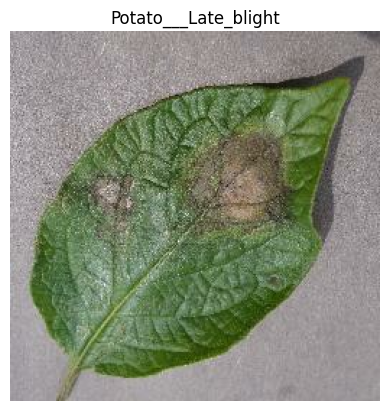

In [7]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

Divinding dataset into test and train. 80% training and 20% (10% validation and 10% test)

In [8]:
training_size = 0.8
len(dataset)*training_size

54.400000000000006

In [9]:
train = dataset.take(54)

In [10]:
test = dataset.skip(54)

In [11]:
val = test.take(6)

In [12]:
test = test.skip(6)

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size= 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

Optimazing the dataset for training

In [14]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Preprocessing pileline

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Modeling

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape), #32 from tryiel and error
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val
)

Epoch 1/50
54/54 [==============================] - 3s 61ms/step - loss: 0.0230 - accuracy: 0.9907 - val_loss: 0.0954 - val_accuracy: 0.9844
Epoch 2/50
54/54 [==============================] - 3s 60ms/step - loss: 0.0205 - accuracy: 0.9936 - val_loss: 0.0287 - val_accuracy: 0.9948
Epoch 3/50
54/54 [==============================] - 3s 62ms/step - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.2004 - val_accuracy: 0.9479
Epoch 4/50
54/54 [==============================] - 3s 62ms/step - loss: 0.0122 - accuracy: 0.9954 - val_loss: 0.0144 - val_accuracy: 0.9896
Epoch 5/50
54/54 [==============================] - 3s 61ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 6/50
54/54 [==============================] - 3s 61ms/step - loss: 0.0159 - accuracy: 0.9936 - val_loss: 0.0141 - val_accuracy: 0.9948
Epoch 7/50
54/54 [==============================] - 3s 62ms/step - loss: 0.0629 - accuracy: 0.9861 - val_loss: 0.1908 - val_accuracy: 0.9271
Epoch 8/50
54

In [27]:
scores = model.evaluate(test)

8/8 [==============================] - 2s 28ms/step - loss: 0.0177 - accuracy: 0.9914


In [28]:
scores

[0.017708761617541313, 0.9913793206214905]

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Loss')

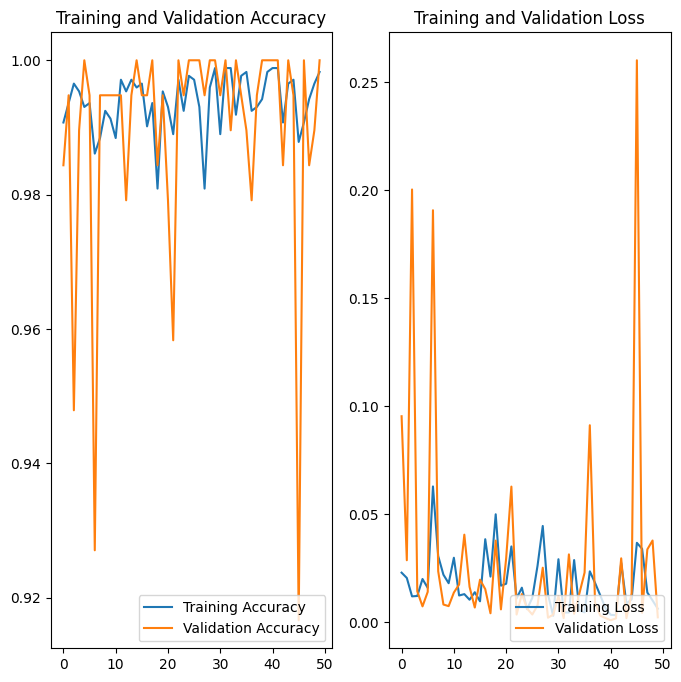

In [35]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')



In [40]:
import numpy as np


First image to predict
First image's actual label:  Potato___Late_blight
1/1 [==============================] - 0s 31ms/step
Predicted label:  Potato___Late_blight


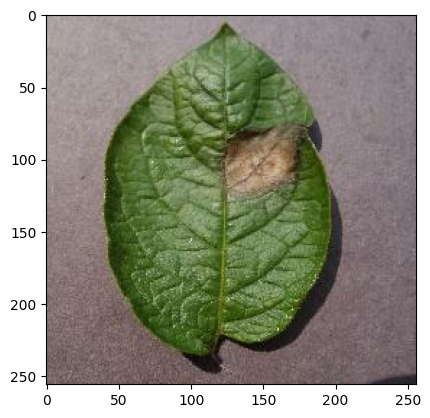

In [43]:
for images_batch, labels_batch in test.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0]

  print("First image to predict")
  plt.imshow(first_image)
  print("First image's actual label: ", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  print(img_array.shape)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 38ms/step


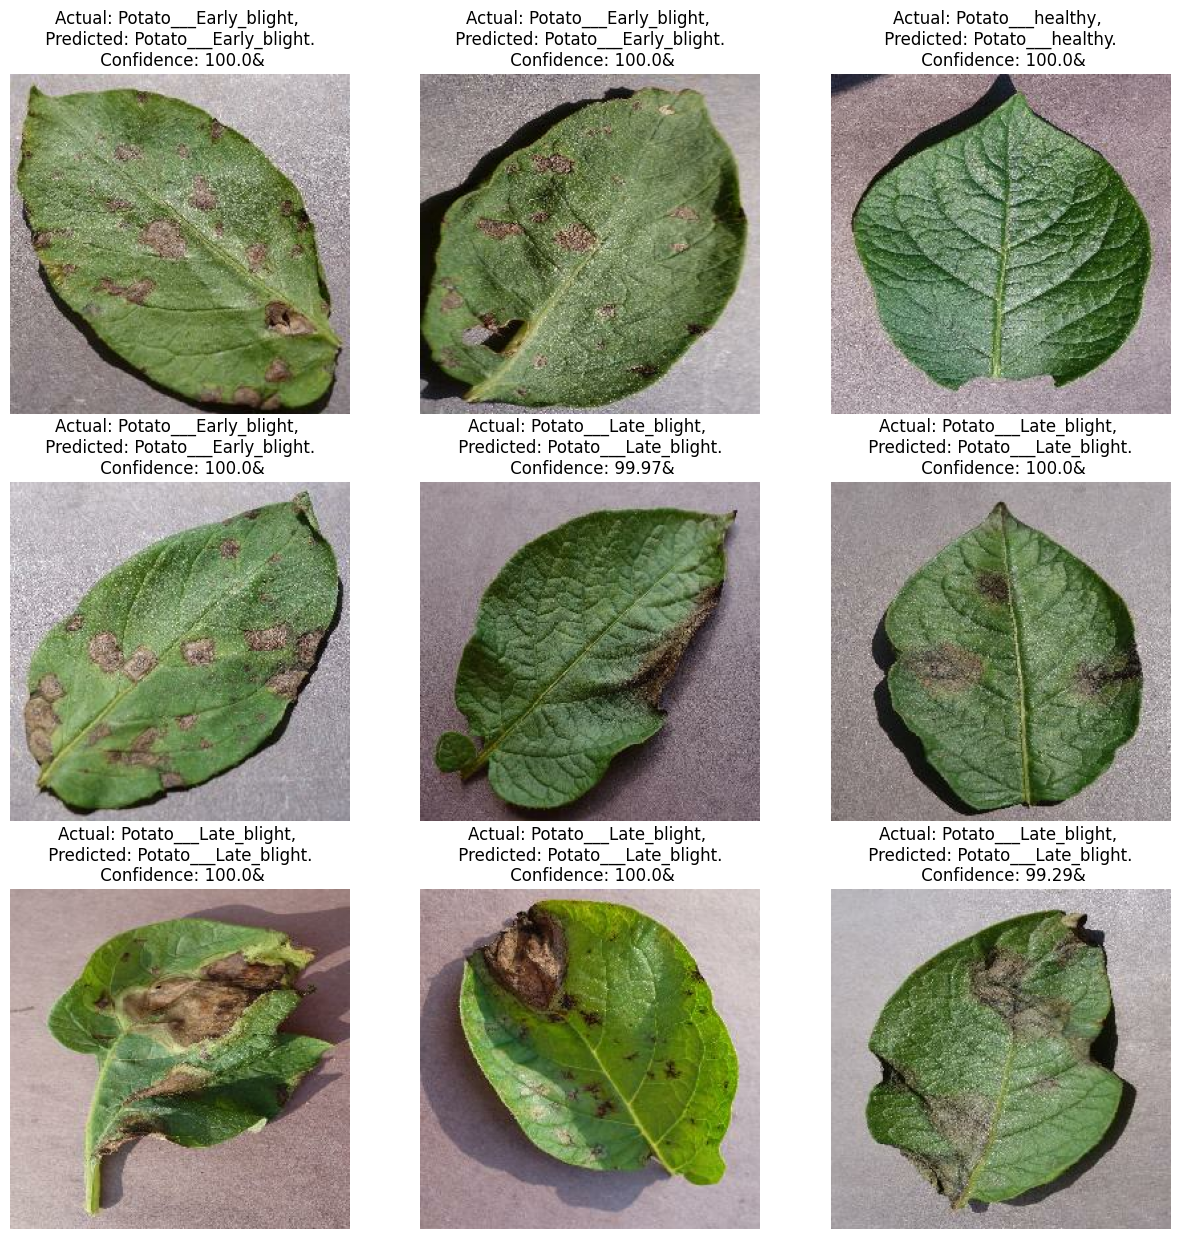

In [46]:
plt.figure(figsize=(15,15))
for images, labels in test.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")

    plt.axis('off')


In [47]:
model_version = 1
model.save(f"../models/{model_version}")

Download model locally

In [52]:
!zip -r models.zip /models

  adding: models/ (stored 0%)
  adding: models/1/ (stored 0%)
  adding: models/1/assets/ (stored 0%)
  adding: models/1/fingerprint.pb (stored 0%)
  adding: models/1/variables/ (stored 0%)
  adding: models/1/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: models/1/variables/variables.index (deflated 68%)
  adding: models/1/saved_model.pb (deflated 89%)
  adding: models/1/keras_metadata.pb (deflated 94%)
